# Weather Data Visualization - Occitanie Region

This notebook visualizes weather data from MongoDB for 6 cities in the Occitanie region:
- Toulouse
- Montpellier
- Perpignan
- Carcassonne
- Nîmes
- Albi

**Data source**: MongoDB `weather.raw_weather` collection

**Weather parameters**:
- temperature_2m
- precipitation
- wind_speed_10m
- wind_direction_10m
- relative_humidity_2m
- pressure_msl
- soil_temperature_0_to_7cm
- soil_moisture_0_to_7cm
- cloud_cover

## Section 1: Setup and Configuration

In [1]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from datetime import datetime, timedelta
import warnings
import json
import os

warnings.filterwarnings('ignore')
print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Cell 2: Set visualization styles
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

# Color palette for 6 cities
CITY_COLORS = sns.color_palette("husl", 6)
print("Visualization styles configured")

Visualization styles configured


In [3]:
# Cell 3: Define constants
CITIES = ['Toulouse', 'Montpellier', 'Perpignan', 'Carcassonne', 'Nîmes', 'Albi']

WEATHER_PARAMS = [
    'temperature_2m',
    'precipitation',
    'wind_speed_10m',
    'wind_direction_10m',
    'relative_humidity_2m',
    'pressure_msl',
    'soil_temperature_0_to_7cm',
    'soil_moisture_0_to_7cm',
    'cloud_cover'
]

# Parameter display names
PARAM_LABELS = {
    'temperature_2m': 'Temperature (°C)',
    'precipitation': 'Precipitation (mm)',
    'wind_speed_10m': 'Wind Speed (km/h)',
    'wind_direction_10m': 'Wind Direction (°)',
    'relative_humidity_2m': 'Relative Humidity (%)',
    'pressure_msl': 'Pressure (hPa)',
    'soil_temperature_0_to_7cm': 'Soil Temperature (°C)',
    'soil_moisture_0_to_7cm': 'Soil Moisture (m³/m³)',
    'cloud_cover': 'Cloud Cover (%)'
}

print(f"Cities: {len(CITIES)}")
print(f"Weather parameters: {len(WEATHER_PARAMS)}")

Cities: 6
Weather parameters: 9


In [4]:
# Cell 4: MongoDB connection details
MONGO_USER = os.getenv('MONGO_INITDB_ROOT_USERNAME', 'admin')
MONGO_PASS = os.getenv('MONGO_INITDB_ROOT_PASSWORD', 'admin')
MONGO_HOST = 'localhost'  # Running outside Docker
MONGO_PORT = '27017'
DB_NAME = 'weather'
COLLECTION_NAME = 'raw_weather'

CONNECTION_STRING = f'mongodb://{MONGO_USER}:{MONGO_PASS}@{MONGO_HOST}:{MONGO_PORT}/'
print(f"MongoDB connection configured: {MONGO_HOST}:{MONGO_PORT}")

MongoDB connection configured: localhost:27017


In [5]:
# Cell 5: Test MongoDB connection
try:
    client = MongoClient(CONNECTION_STRING, serverSelectionTimeoutMS=5000)
    # Test connection
    client.server_info()
    db = client[DB_NAME]
    collection = db[COLLECTION_NAME]
    
    # Get collection stats
    doc_count = collection.count_documents({})
    print(f"✓ Connected to MongoDB successfully")
    print(f"✓ Database: {DB_NAME}")
    print(f"✓ Collection: {COLLECTION_NAME}")
    print(f"✓ Total documents: {doc_count:,}")
    
except Exception as e:
    print(f"✗ MongoDB connection failed: {e}")
    print("\nMake sure MongoDB is running: docker-compose up -d mongodb")

✓ Connected to MongoDB successfully
✓ Database: weather
✓ Collection: raw_weather
✓ Total documents: 1,631


## Section 2: Helper Functions

In [6]:
# Cell 6: Connect to MongoDB function
def connect_to_mongodb():
    """
    Establish MongoDB connection and return collection object.
    
    Returns:
        pymongo.collection.Collection: MongoDB collection object
    """
    try:
        client = MongoClient(CONNECTION_STRING, serverSelectionTimeoutMS=5000)
        db = client[DB_NAME]
        collection = db[COLLECTION_NAME]
        return collection
    except Exception as e:
        print(f"Error connecting to MongoDB: {e}")
        return None

print("✓ connect_to_mongodb() defined")

✓ connect_to_mongodb() defined


In [7]:
# Cell 7: Get latest data function
def get_latest_data(hours=24, cities=None):
    """
    Query recent weather data with time filter.
    
    Args:
        hours (int): Number of hours to look back (default: 24)
        cities (list): List of city names to filter (default: all cities)
    
    Returns:
        list: List of MongoDB documents
    """
    collection = connect_to_mongodb()
    if collection is None:
        return []
    
    # Calculate time threshold
    time_threshold = datetime.now() - timedelta(hours=hours)
    
    # Build query
    query = {'timestamp': {'$gte': time_threshold}}
    
    if cities:
        query['city'] = {'$in': cities}
    
    # Execute query
    documents = list(collection.find(query).sort('timestamp', -1))
    
    print(f"Retrieved {len(documents)} documents from last {hours} hours")
    return documents

print("✓ get_latest_data() defined")

✓ get_latest_data() defined


In [8]:
# Cell 8: Flatten document function
def flatten_document(doc):
    """
    Convert nested MongoDB document to flat pandas DataFrame.
    
    Args:
        doc (dict): MongoDB document with nested data.hourly structure
    
    Returns:
        pd.DataFrame: Flattened DataFrame with time index
    """
    try:
        # Extract hourly data
        hourly_data = doc['data']['hourly']
        
        # Create DataFrame
        df = pd.DataFrame(hourly_data)
        
        # Convert time to datetime
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
        
        # Add metadata columns
        df['city'] = doc['city']
        df['latitude'] = doc['latitude']
        df['longitude'] = doc['longitude']
        df['ingestion_timestamp'] = doc['ingestion_timestamp']
        
        return df
    
    except KeyError as e:
        print(f"Error flattening document: missing key {e}")
        return pd.DataFrame()

print("✓ flatten_document() defined")

✓ flatten_document() defined


In [9]:
# Cell 9: Combine documents function
def combine_documents(documents):
    """
    Merge multiple MongoDB documents into single DataFrame.
    
    Args:
        documents (list): List of MongoDB documents
    
    Returns:
        pd.DataFrame: Combined DataFrame sorted by time
    """
    if not documents:
        print("No documents to combine")
        return pd.DataFrame()
    
    # Flatten each document
    dfs = []
    for doc in documents:
        df = flatten_document(doc)
        if not df.empty:
            dfs.append(df)
    
    if not dfs:
        print("No valid data frames created")
        return pd.DataFrame()
    
    # Combine all DataFrames
    combined = pd.concat(dfs, ignore_index=False)
    combined.sort_index(inplace=True)
    
    print(f"Combined {len(dfs)} documents into DataFrame with {len(combined)} rows")
    return combined

print("✓ combine_documents() defined")

✓ combine_documents() defined


In [10]:
# Cell 10: Get city data function
def get_city_data(city, hours=24):
    """
    Get weather data for a specific city.
    
    Args:
        city (str): City name
        hours (int): Number of hours to look back
    
    Returns:
        pd.DataFrame: Weather data for the city
    """
    documents = get_latest_data(hours=hours, cities=[city])
    return combine_documents(documents)

print("✓ get_city_data() defined")

✓ get_city_data() defined


In [11]:
# Cell 11: Get all cities data function
def get_all_cities_data(hours=24):
    """
    Get weather data for all cities.
    
    Args:
        hours (int): Number of hours to look back
    
    Returns:
        pd.DataFrame: Weather data for all cities
    """
    documents = get_latest_data(hours=hours, cities=CITIES)
    return combine_documents(documents)

print("✓ get_all_cities_data() defined")

✓ get_all_cities_data() defined


In [12]:
# Cell 12: Error handling test
# Test helper functions with sample query
try:
    test_docs = get_latest_data(hours=1, cities=['Toulouse'])
    if test_docs:
        test_df = combine_documents(test_docs)
        print(f"✓ Helper functions working correctly")
        print(f"✓ Sample data retrieved: {len(test_df)} rows")
    else:
        print("⚠ No data available yet. Run the DAG to collect data first.")
except Exception as e:
    print(f"✗ Error testing helper functions: {e}")

Retrieved 0 documents from last 1 hours
⚠ No data available yet. Run the DAG to collect data first.


## Section 3: Data Exploration

In [14]:
# Cell 13: Database statistics
collection = connect_to_mongodb()

if collection is not None:
    total_docs = collection.count_documents({})
    
    # Get date range
    oldest = collection.find_one(sort=[('timestamp', 1)])
    newest = collection.find_one(sort=[('timestamp', -1)])
    
    print("=" * 50)
    print("DATABASE STATISTICS")
    print("=" * 50)
    print(f"Total documents: {total_docs:,}")
    
    if oldest and newest:
        print(f"Oldest record: {oldest['timestamp']}")
        print(f"Newest record: {newest['timestamp']}")
        time_span = newest['timestamp'] - oldest['timestamp']
        print(f"Time span: {time_span}")
    
    # Count by city
    print("\nDocuments per city:")
    for city in CITIES:
        count = collection.count_documents({'city': city})
        print(f"  {city}: {count:,}")
    
    print("=" * 50)

DATABASE STATISTICS
Total documents: 1,649
Oldest record: 2026-02-04 14:18:01.315000
Newest record: 2026-02-04 15:03:31.849000
Time span: 0:45:30.534000

Documents per city:
  Toulouse: 274
  Montpellier: 275
  Perpignan: 275
  Carcassonne: 275
  Nîmes: 275
  Albi: 275


In [15]:
# Cell 14: Sample document structure
sample_doc = collection.find_one()

if sample_doc:
    print("SAMPLE DOCUMENT STRUCTURE")
    print("=" * 50)
    print(f"City: {sample_doc.get('city')}")
    print(f"Latitude: {sample_doc.get('latitude')}")
    print(f"Longitude: {sample_doc.get('longitude')}")
    print(f"Timestamp: {sample_doc.get('timestamp')}")
    print(f"\nData keys: {list(sample_doc.get('data', {}).keys())}")
    
    if 'hourly' in sample_doc.get('data', {}):
        hourly_keys = list(sample_doc['data']['hourly'].keys())
        print(f"Hourly data parameters: {hourly_keys}")
        print(f"Number of hourly records: {len(sample_doc['data']['hourly'].get('time', []))}")

SAMPLE DOCUMENT STRUCTURE
City: Toulouse
Latitude: 43.6047
Longitude: 1.4442
Timestamp: 2026-02-04 14:18:01.315000

Data keys: ['latitude', 'longitude', 'generationtime_ms', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation', 'elevation', 'hourly_units', 'hourly']
Hourly data parameters: ['time', 'temperature_2m', 'precipitation', 'wind_speed_10m', 'wind_direction_10m', 'relative_humidity_2m', 'pressure_msl', 'soil_temperature_0_to_7cm', 'soil_moisture_0_to_7cm', 'cloud_cover']
Number of hourly records: 168


In [16]:
# Cell 15: Query and display latest data
print("Fetching latest 24 hours of data for all cities...\n")
df_all = get_all_cities_data(hours=24)

if not df_all.empty:
    print(f"DataFrame shape: {df_all.shape}")
    print(f"\nColumns: {list(df_all.columns)}")
    print(f"\nTime range: {df_all.index.min()} to {df_all.index.max()}")
    print(f"\nFirst few rows:")
    display(df_all.head())
else:
    print("⚠ No data available. Please run the DAG to collect data.")

Fetching latest 24 hours of data for all cities...

Retrieved 1655 documents from last 24 hours
Combined 1655 documents into DataFrame with 278040 rows
DataFrame shape: (278040, 13)

Columns: ['temperature_2m', 'precipitation', 'wind_speed_10m', 'wind_direction_10m', 'relative_humidity_2m', 'pressure_msl', 'soil_temperature_0_to_7cm', 'soil_moisture_0_to_7cm', 'cloud_cover', 'city', 'latitude', 'longitude', 'ingestion_timestamp']

Time range: 2026-02-04 00:00:00 to 2026-02-10 23:00:00

First few rows:


,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,relative_humidity_2m,pressure_msl,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm,cloud_cover,city,latitude,longitude,ingestion_timestamp
time,,,,,,,,,,,,,
2026-02-04,6.4,0.0,3.5,66,89,997.9,None,None,0,Albi,43.9298,2.1480,2026-02-04 15:03:42.194
2026-02-04,8.9,0.0,11.7,99,91,1001.3,None,None,99,Nîmes,43.8367,4.3601,2026-02-04 14:25:32.176
2026-02-04,7.4,0.0,3.3,131,73,998.0,None,None,0,Perpignan,42.6886,2.8948,2026-02-04 14:56:01.930
2026-02-04,6.4,0.0,3.5,66,89,997.9,None,None,0,Albi,43.9298,2.1480,2026-02-04 14:25:32.380
2026-02-04,8.8,0.0,9.0,37,95,1000.5,None,None,93,Montpellier,43.6108,3.8767,2026-02-04 14:56:01.728


In [17]:
# Cell 16: Data quality checks
if not df_all.empty:
    print("DATA QUALITY REPORT")
    print("=" * 50)
    
    # Missing values
    print("\nMissing values by column:")
    missing = df_all.isnull().sum()
    missing_pct = (missing / len(df_all) * 100).round(2)
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Percentage': missing_pct
    })
    print(missing_df[missing_df['Missing Count'] > 0])
    
    # Check for outliers (simple Z-score method)
    print("\nChecking for outliers (|Z-score| > 3):")
    for param in WEATHER_PARAMS:
        if param in df_all.columns:
            z_scores = np.abs((df_all[param] - df_all[param].mean()) / df_all[param].std())
            outliers = (z_scores > 3).sum()
            if outliers > 0:
                print(f"  {param}: {outliers} outliers ({outliers/len(df_all)*100:.2f}%)")

DATA QUALITY REPORT

Missing values by column:
                           Missing Count  Percentage
soil_temperature_0_to_7cm         278040       100.0
soil_moisture_0_to_7cm            278040       100.0

Checking for outliers (|Z-score| > 3):
  precipitation: 4413 outliers (1.59%)
  wind_speed_10m: 5520 outliers (1.99%)
  relative_humidity_2m: 1656 outliers (0.60%)


In [18]:
# Cell 17: Summary statistics table
if not df_all.empty:
    print("SUMMARY STATISTICS")
    print("=" * 50)
    
    # Select only weather parameters
    weather_cols = [col for col in WEATHER_PARAMS if col in df_all.columns]
    summary = df_all[weather_cols].describe().T
    
    # Add parameter labels
    summary.index = [PARAM_LABELS.get(idx, idx) for idx in summary.index]
    
    display(summary.round(2))

SUMMARY STATISTICS


,count,mean,std,min,25%,50%,75%,max
Temperature (°C),278040.0,8.47,2.90,-0.0,6.4,8.5,10.52,16.0
Precipitation (mm),278040.0,0.10,0.39,0.0,0.0,0.0,0.00,5.4
Wind Speed (km/h),278040.0,7.80,5.66,0.5,4.0,6.0,9.70,32.6
Wind Direction (°),278040.0,184.22,104.23,1.0,92.0,177.0,279.00,360.0
Relative Humidity (%),278040.0,83.44,11.70,45.0,78.0,87.0,92.00,100.0
Pressure (hPa),278040.0,1000.80,6.85,984.9,994.3,1002.5,1006.70,1011.1
Cloud Cover (%),278040.0,73.22,35.58,0.0,52.0,94.0,100.00,100.0


## Section 4: Time Series Visualizations

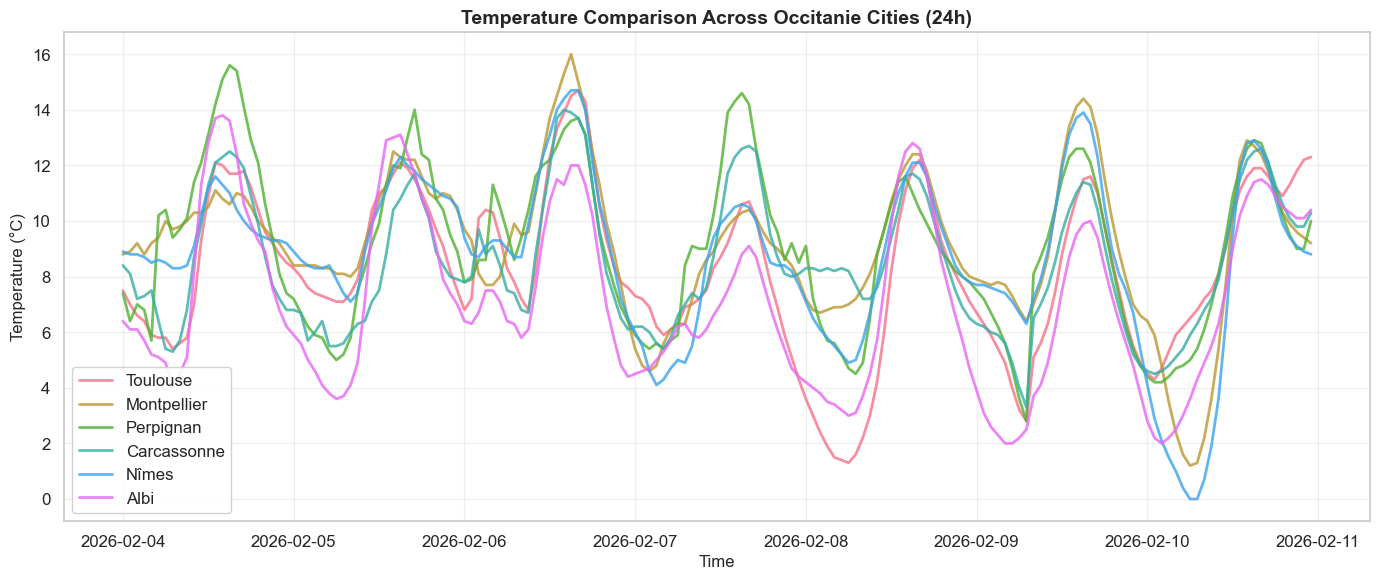

In [19]:
# Cell 18: Multi-city temperature comparison
if not df_all.empty and 'temperature_2m' in df_all.columns:
    plt.figure(figsize=(14, 6))
    
    for i, city in enumerate(CITIES):
        city_data = df_all[df_all['city'] == city]
        if not city_data.empty:
            plt.plot(city_data.index, city_data['temperature_2m'], 
                    label=city, color=CITY_COLORS[i], linewidth=2, alpha=0.8)
    
    plt.title('Temperature Comparison Across Occitanie Cities (24h)', fontsize=14, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.legend(loc='best', framealpha=0.9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Insufficient data for temperature visualization")

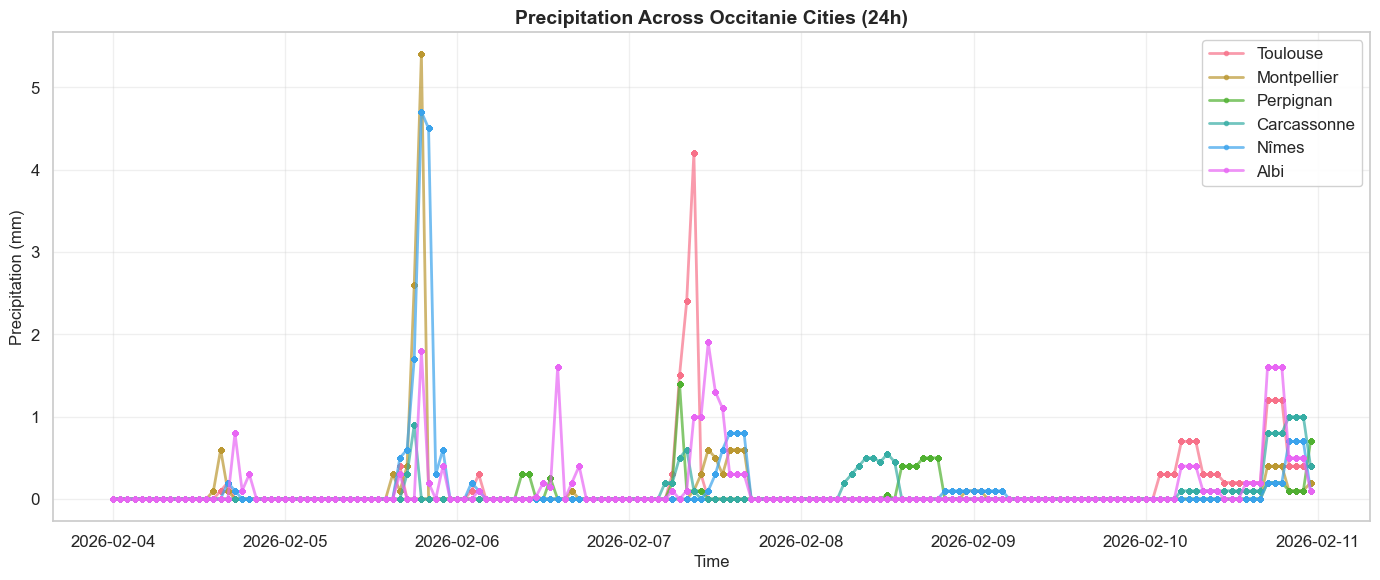

In [20]:
# Cell 19: Precipitation over time
if not df_all.empty and 'precipitation' in df_all.columns:
    plt.figure(figsize=(14, 6))
    
    for i, city in enumerate(CITIES):
        city_data = df_all[df_all['city'] == city]
        if not city_data.empty:
            plt.plot(city_data.index, city_data['precipitation'], 
                    label=city, color=CITY_COLORS[i], linewidth=2, alpha=0.7, marker='o', markersize=3)
    
    plt.title('Precipitation Across Occitanie Cities (24h)', fontsize=14, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Precipitation (mm)', fontsize=12)
    plt.legend(loc='best', framealpha=0.9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Insufficient data for precipitation visualization")

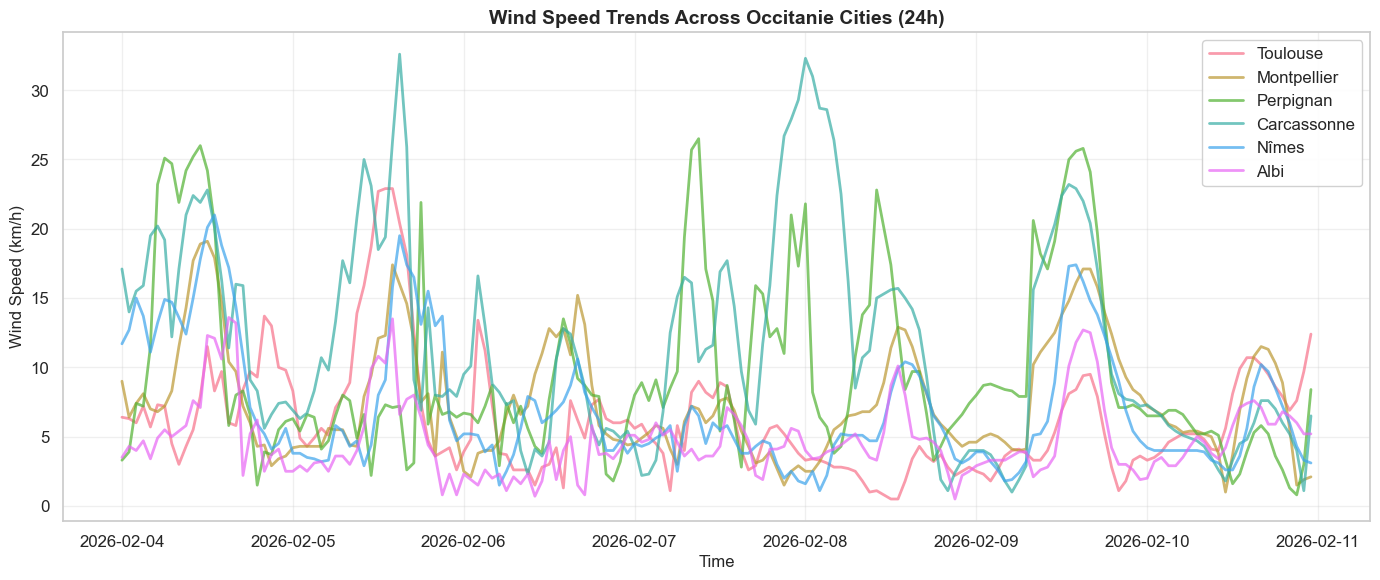

In [21]:
# Cell 20: Wind speed trends
if not df_all.empty and 'wind_speed_10m' in df_all.columns:
    plt.figure(figsize=(14, 6))
    
    for i, city in enumerate(CITIES):
        city_data = df_all[df_all['city'] == city]
        if not city_data.empty:
            plt.plot(city_data.index, city_data['wind_speed_10m'], 
                    label=city, color=CITY_COLORS[i], linewidth=2, alpha=0.7)
    
    plt.title('Wind Speed Trends Across Occitanie Cities (24h)', fontsize=14, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Wind Speed (km/h)', fontsize=12)
    plt.legend(loc='best', framealpha=0.9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Insufficient data for wind speed visualization")

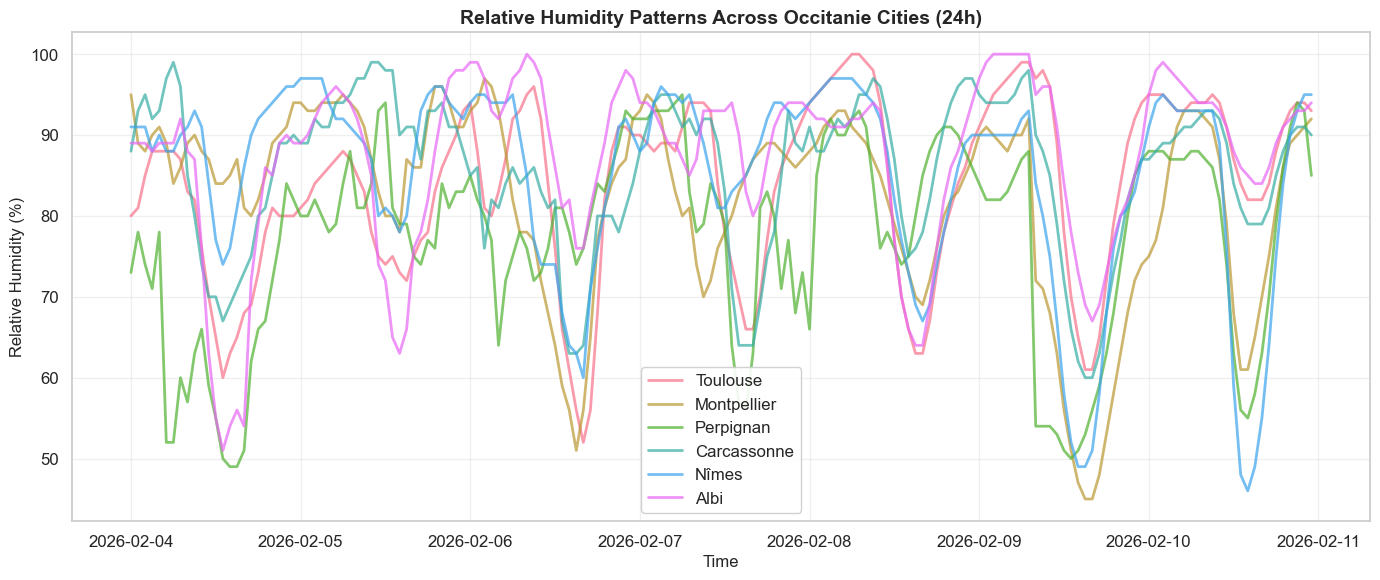

In [22]:
# Cell 21: Humidity patterns
if not df_all.empty and 'relative_humidity_2m' in df_all.columns:
    plt.figure(figsize=(14, 6))
    
    for i, city in enumerate(CITIES):
        city_data = df_all[df_all['city'] == city]
        if not city_data.empty:
            plt.plot(city_data.index, city_data['relative_humidity_2m'], 
                    label=city, color=CITY_COLORS[i], linewidth=2, alpha=0.7)
    
    plt.title('Relative Humidity Patterns Across Occitanie Cities (24h)', fontsize=14, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Relative Humidity (%)', fontsize=12)
    plt.legend(loc='best', framealpha=0.9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Insufficient data for humidity visualization")

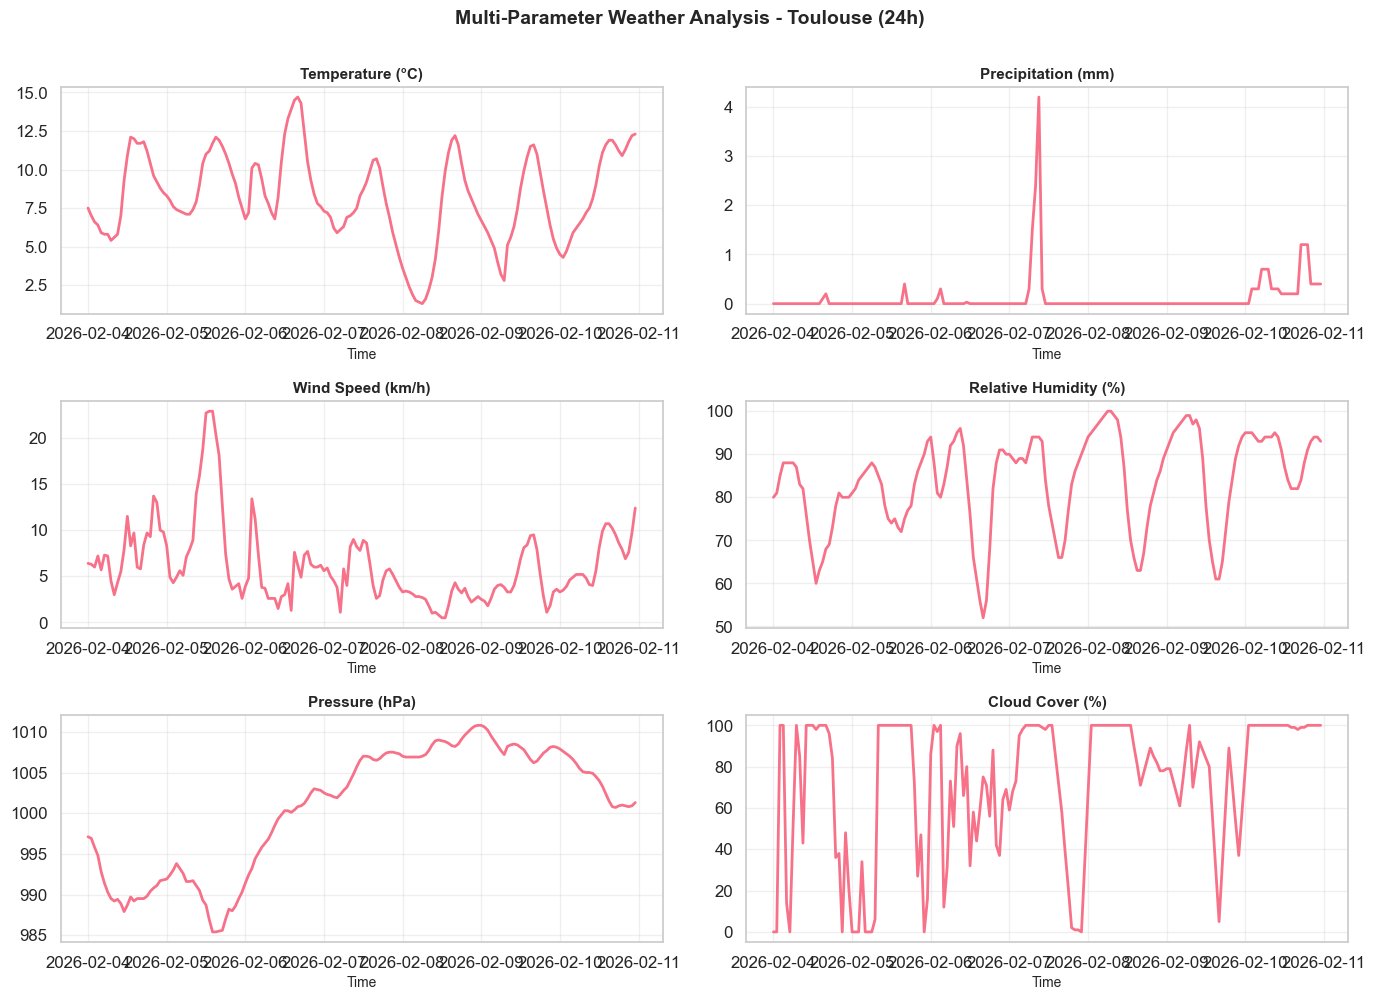

In [23]:
# Cell 22: Multi-parameter for single city (Toulouse)
if not df_all.empty:
    toulouse_data = df_all[df_all['city'] == 'Toulouse']
    
    if not toulouse_data.empty:
        # Select parameters to plot (exclude wind direction for clarity)
        params_to_plot = ['temperature_2m', 'precipitation', 'wind_speed_10m', 
                         'relative_humidity_2m', 'pressure_msl', 'cloud_cover']
        
        fig, axes = plt.subplots(3, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        for idx, param in enumerate(params_to_plot):
            if param in toulouse_data.columns:
                axes[idx].plot(toulouse_data.index, toulouse_data[param], 
                             color=CITY_COLORS[0], linewidth=2)
                axes[idx].set_title(PARAM_LABELS.get(param, param), fontsize=11, fontweight='bold')
                axes[idx].set_xlabel('Time', fontsize=10)
                axes[idx].grid(True, alpha=0.3)
        
        plt.suptitle('Multi-Parameter Weather Analysis - Toulouse (24h)', 
                    fontsize=14, fontweight='bold', y=1.00)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠ No data available for Toulouse")
else:
    print("⚠ Insufficient data for multi-parameter visualization")

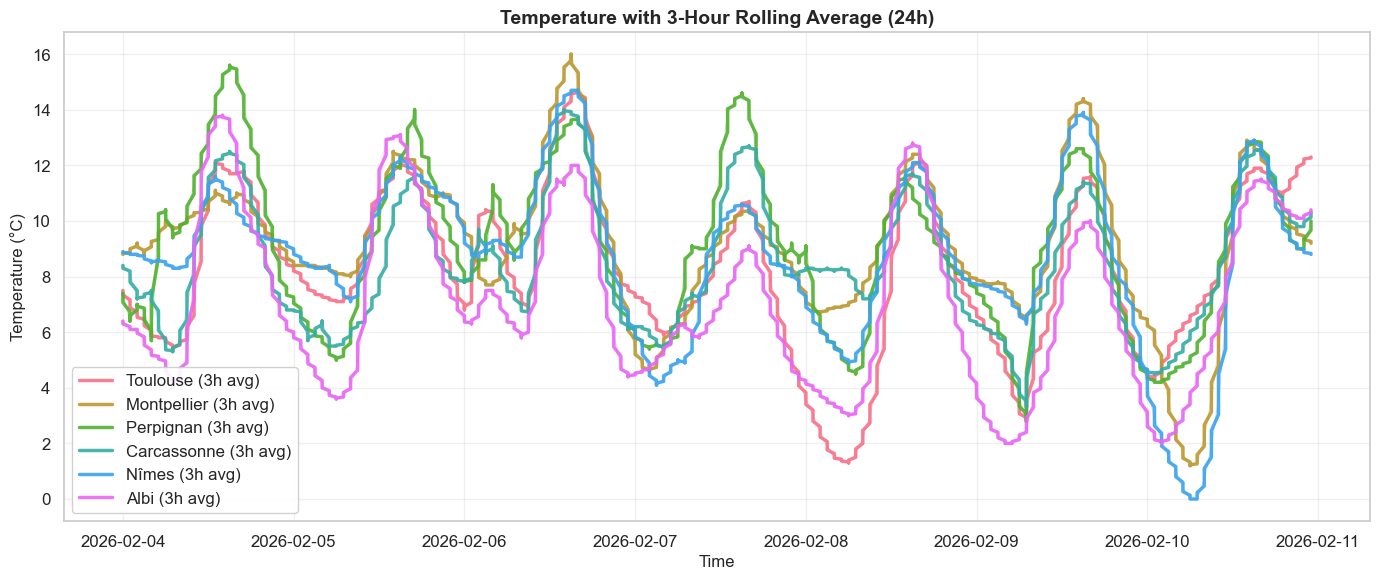

In [24]:
# Cell 23: 24-hour rolling averages for temperature
if not df_all.empty and 'temperature_2m' in df_all.columns:
    plt.figure(figsize=(14, 6))
    
    for i, city in enumerate(CITIES):
        city_data = df_all[df_all['city'] == city].copy()
        if not city_data.empty and len(city_data) > 1:
            # Calculate rolling average (window of 3 hours = 3 data points)
            city_data['temp_rolling'] = city_data['temperature_2m'].rolling(window=3, center=True).mean()
            
            # Plot original
            plt.plot(city_data.index, city_data['temperature_2m'], 
                    color=CITY_COLORS[i], linewidth=1, alpha=0.3)
            # Plot rolling average
            plt.plot(city_data.index, city_data['temp_rolling'], 
                    label=f'{city} (3h avg)', color=CITY_COLORS[i], linewidth=2.5, alpha=0.9)
    
    plt.title('Temperature with 3-Hour Rolling Average (24h)', fontsize=14, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.legend(loc='best', framealpha=0.9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Insufficient data for rolling average visualization")

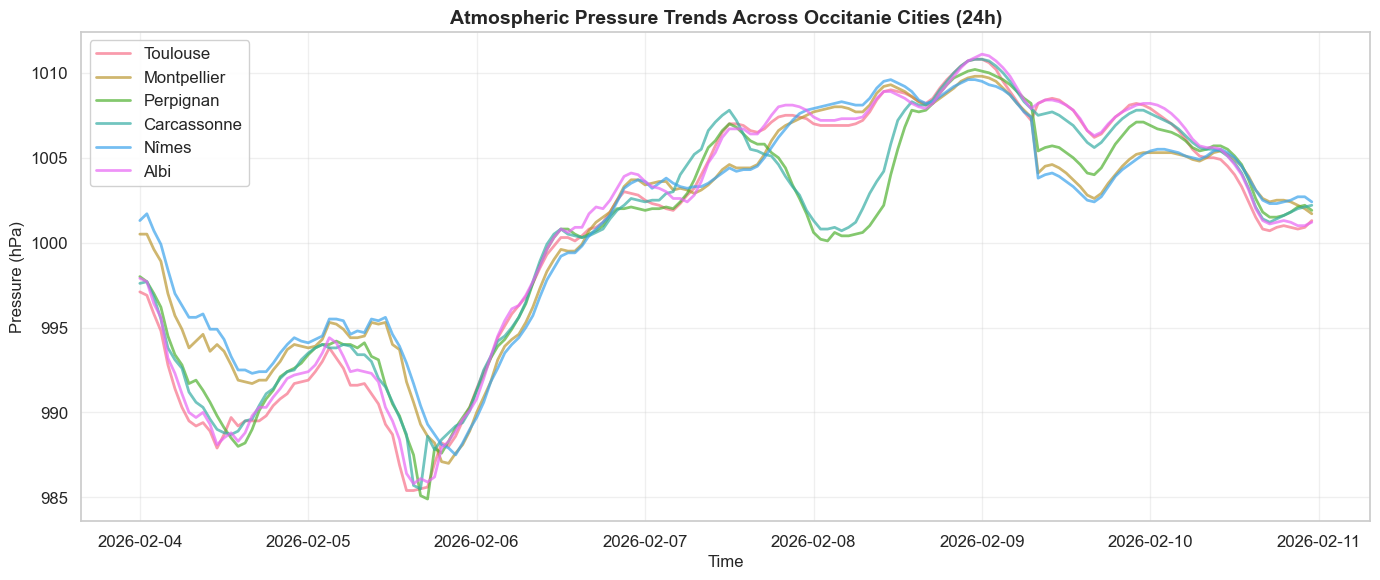

In [25]:
# Cell 24: Pressure trends
if not df_all.empty and 'pressure_msl' in df_all.columns:
    plt.figure(figsize=(14, 6))
    
    for i, city in enumerate(CITIES):
        city_data = df_all[df_all['city'] == city]
        if not city_data.empty:
            plt.plot(city_data.index, city_data['pressure_msl'], 
                    label=city, color=CITY_COLORS[i], linewidth=2, alpha=0.7)
    
    plt.title('Atmospheric Pressure Trends Across Occitanie Cities (24h)', fontsize=14, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Pressure (hPa)', fontsize=12)
    plt.legend(loc='best', framealpha=0.9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Insufficient data for pressure visualization")

## Section 5: City Comparison Analysis

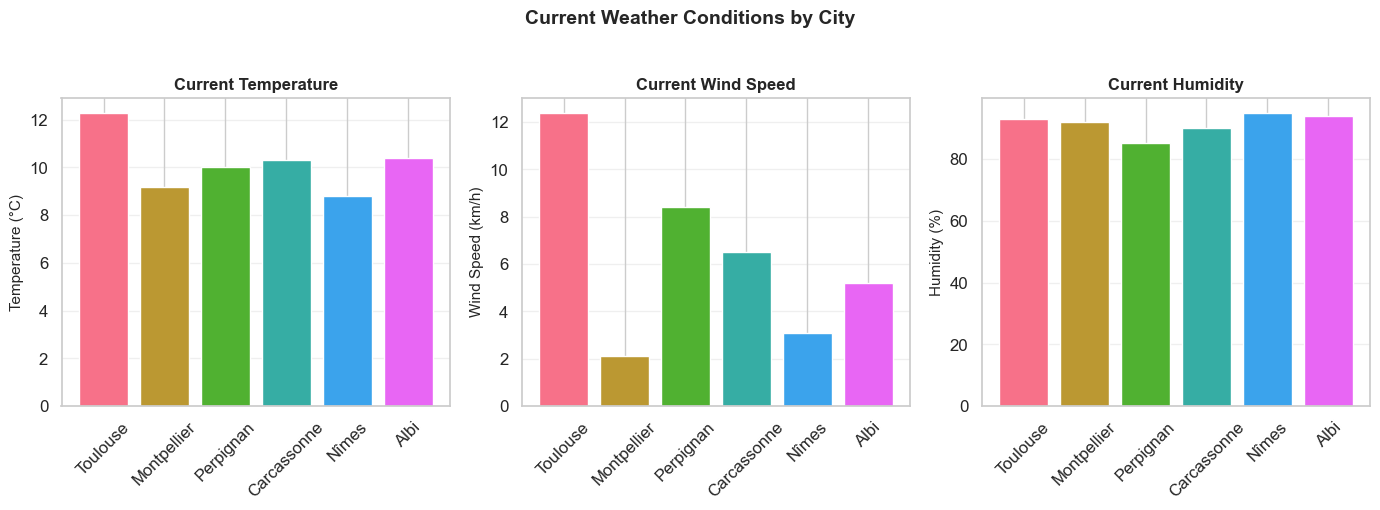

In [26]:
# Cell 25: Current conditions bar chart
if not df_all.empty:
    # Get most recent reading for each city
    latest_data = []
    for city in CITIES:
        city_data = df_all[df_all['city'] == city]
        if not city_data.empty:
            latest = city_data.iloc[-1]
            latest_data.append({
                'City': city,
                'Temperature': latest.get('temperature_2m', np.nan),
                'Wind Speed': latest.get('wind_speed_10m', np.nan),
                'Humidity': latest.get('relative_humidity_2m', np.nan)
            })
    
    if latest_data:
        latest_df = pd.DataFrame(latest_data)
        
        fig, axes = plt.subplots(1, 3, figsize=(14, 5))
        
        # Temperature
        axes[0].bar(latest_df['City'], latest_df['Temperature'], color=CITY_COLORS)
        axes[0].set_title('Current Temperature', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Temperature (°C)', fontsize=11)
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Wind Speed
        axes[1].bar(latest_df['City'], latest_df['Wind Speed'], color=CITY_COLORS)
        axes[1].set_title('Current Wind Speed', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Wind Speed (km/h)', fontsize=11)
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid(True, alpha=0.3, axis='y')
        
        # Humidity
        axes[2].bar(latest_df['City'], latest_df['Humidity'], color=CITY_COLORS)
        axes[2].set_title('Current Humidity', fontsize=12, fontweight='bold')
        axes[2].set_ylabel('Humidity (%)', fontsize=11)
        axes[2].tick_params(axis='x', rotation=45)
        axes[2].grid(True, alpha=0.3, axis='y')
        
        plt.suptitle('Current Weather Conditions by City', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠ No latest data available")
else:
    print("⚠ Insufficient data for current conditions visualization")

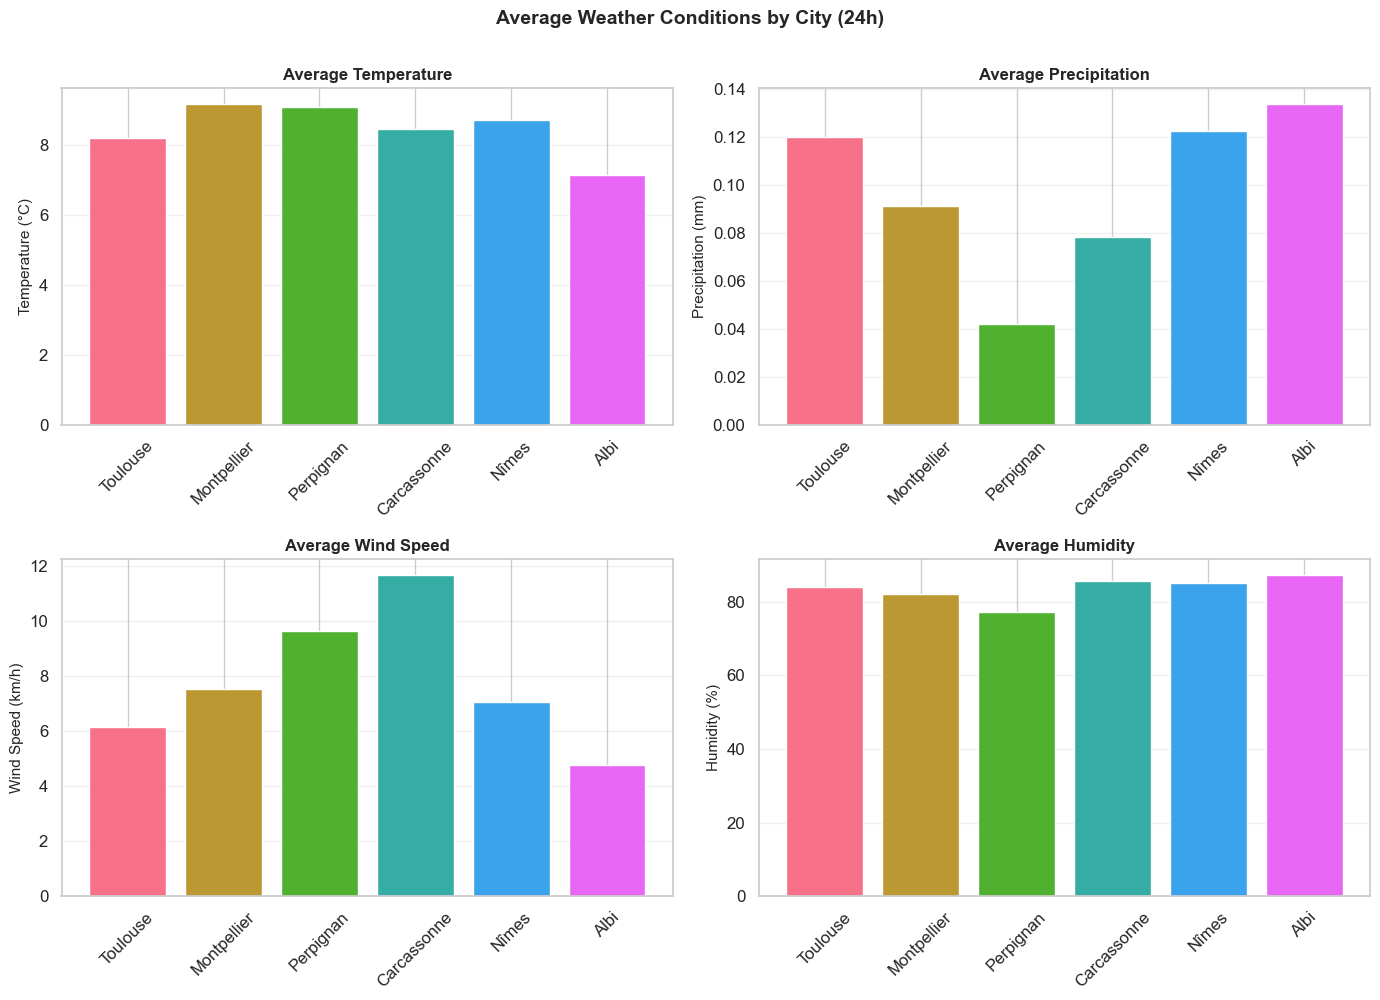

In [27]:
# Cell 26: Average conditions by city
if not df_all.empty:
    # Calculate averages by city
    city_averages = df_all.groupby('city')[['temperature_2m', 'precipitation', 
                                             'wind_speed_10m', 'relative_humidity_2m']].mean()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    params = ['temperature_2m', 'precipitation', 'wind_speed_10m', 'relative_humidity_2m']
    titles = ['Average Temperature', 'Average Precipitation', 'Average Wind Speed', 'Average Humidity']
    ylabels = ['Temperature (°C)', 'Precipitation (mm)', 'Wind Speed (km/h)', 'Humidity (%)']
    
    for idx, (param, title, ylabel) in enumerate(zip(params, titles, ylabels)):
        if param in city_averages.columns:
            data = city_averages[param].reindex(CITIES)
            axes[idx].bar(range(len(CITIES)), data.values, color=CITY_COLORS)
            axes[idx].set_xticks(range(len(CITIES)))
            axes[idx].set_xticklabels(CITIES, rotation=45)
            axes[idx].set_title(title, fontsize=12, fontweight='bold')
            axes[idx].set_ylabel(ylabel, fontsize=11)
            axes[idx].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Average Weather Conditions by City (24h)', fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Insufficient data for average conditions visualization")

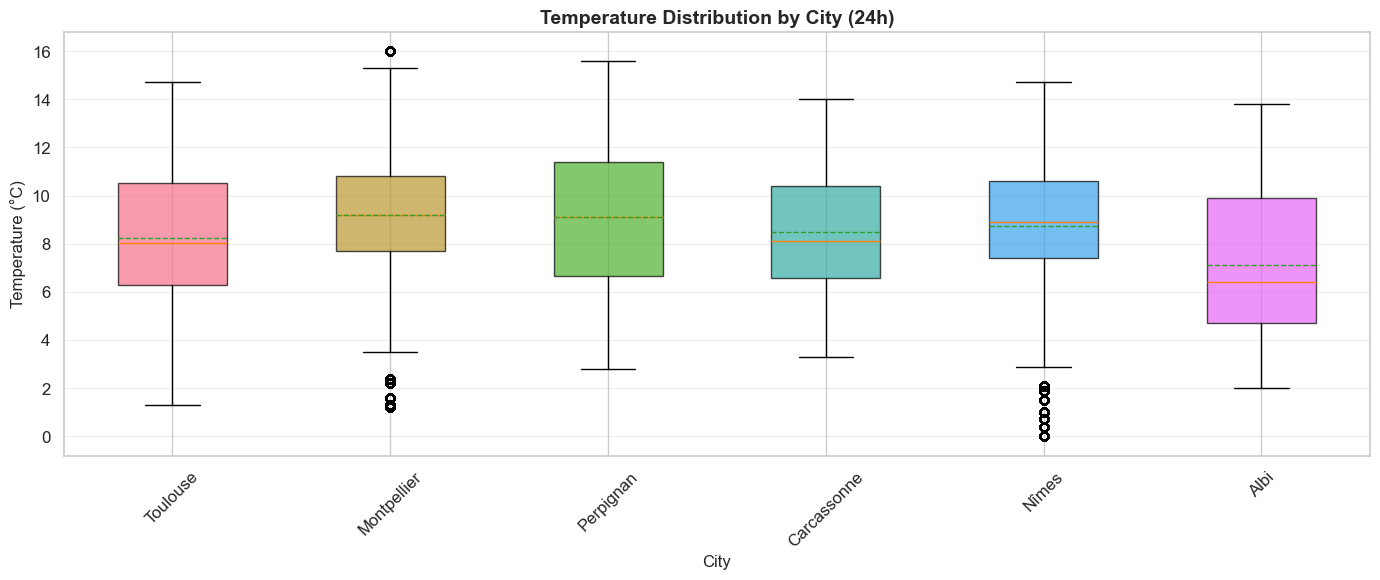

In [28]:
# Cell 27: Box plots by city for temperature
if not df_all.empty and 'temperature_2m' in df_all.columns:
    plt.figure(figsize=(14, 6))
    
    # Prepare data for box plot
    data_by_city = [df_all[df_all['city'] == city]['temperature_2m'].dropna().values 
                    for city in CITIES]
    
    bp = plt.boxplot(data_by_city, labels=CITIES, patch_artist=True, 
                     showmeans=True, meanline=True)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], CITY_COLORS):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.title('Temperature Distribution by City (24h)', fontsize=14, fontweight='bold')
    plt.xlabel('City', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Insufficient data for box plot visualization")

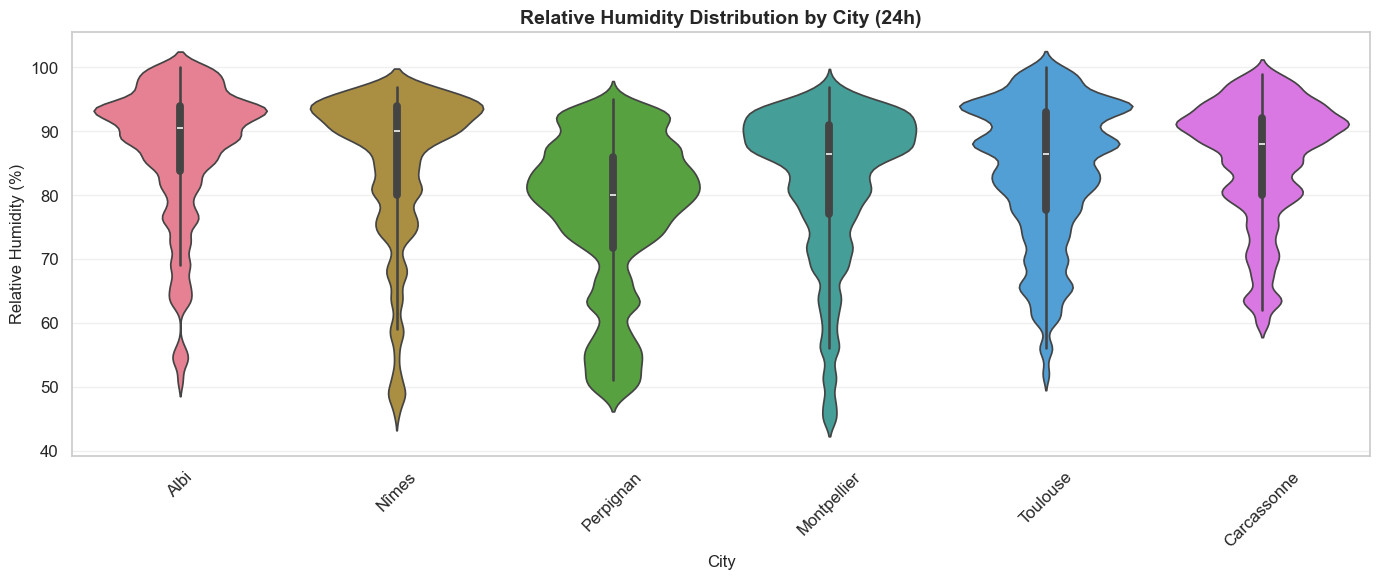

In [29]:
# Cell 28: Violin plots for humidity
if not df_all.empty and 'relative_humidity_2m' in df_all.columns:
    plt.figure(figsize=(14, 6))
    
    # Filter data for plotting
    plot_data = df_all[df_all['city'].isin(CITIES)][['city', 'relative_humidity_2m']].dropna()
    
    if not plot_data.empty:
        sns.violinplot(data=plot_data, x='city', y='relative_humidity_2m', 
                      palette=CITY_COLORS, inner='box')
        
        plt.title('Relative Humidity Distribution by City (24h)', fontsize=14, fontweight='bold')
        plt.xlabel('City', fontsize=12)
        plt.ylabel('Relative Humidity (%)', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    else:
        print("⚠ No valid data for violin plot")
else:
    print("⚠ Insufficient data for violin plot visualization")

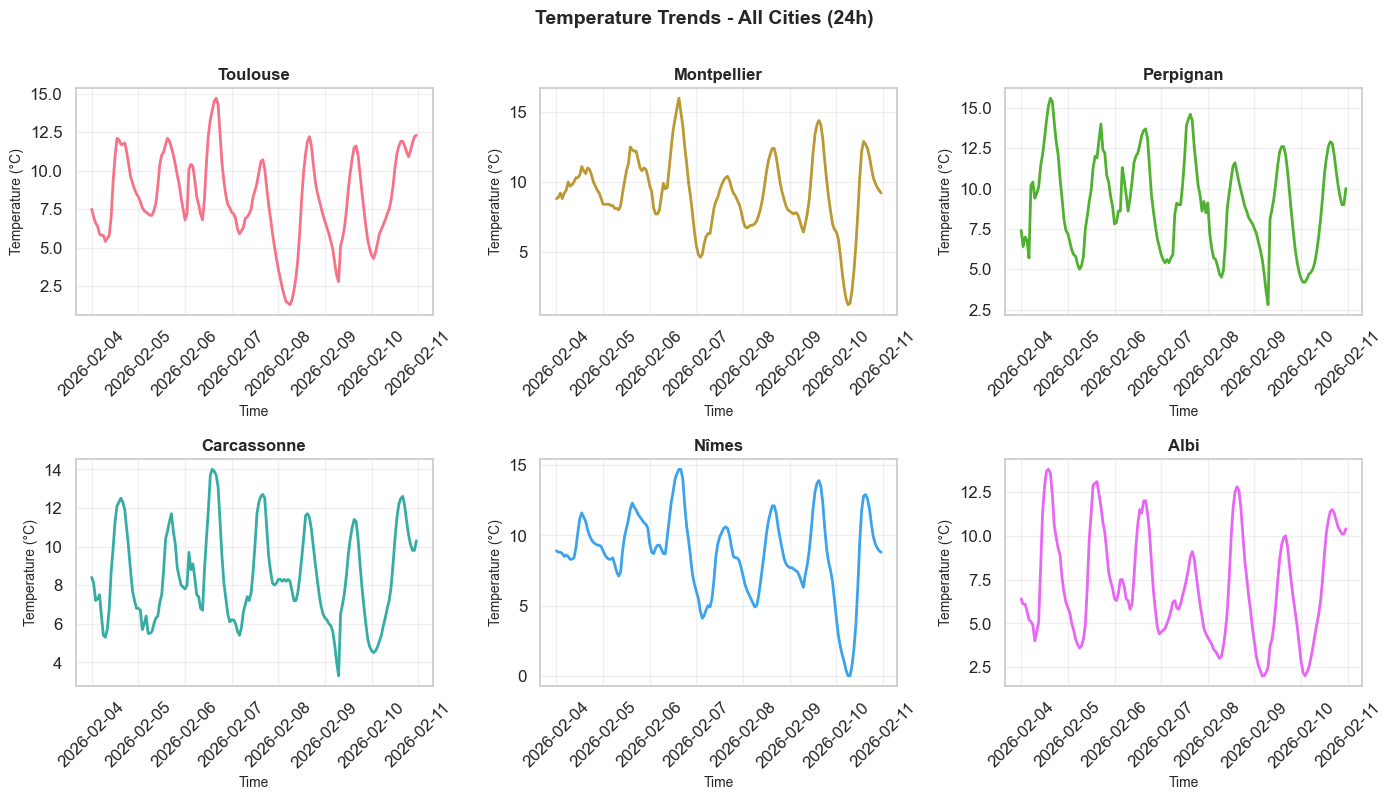

In [30]:
# Cell 29: Small multiples - Temperature grid
if not df_all.empty and 'temperature_2m' in df_all.columns:
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    axes = axes.flatten()
    
    for idx, city in enumerate(CITIES):
        city_data = df_all[df_all['city'] == city]
        if not city_data.empty:
            axes[idx].plot(city_data.index, city_data['temperature_2m'], 
                         color=CITY_COLORS[idx], linewidth=2)
            axes[idx].set_title(city, fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Time', fontsize=10)
            axes[idx].set_ylabel('Temperature (°C)', fontsize=10)
            axes[idx].grid(True, alpha=0.3)
            axes[idx].tick_params(axis='x', rotation=45)
    
    plt.suptitle('Temperature Trends - All Cities (24h)', fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Insufficient data for small multiples visualization")

In [34]:
# Cell 30: City ranking table
if not df_all.empty:
    ranking_data = []
    
    for city in CITIES:
        city_data = df_all[df_all['city'] == city]
        if not city_data.empty:
            ranking_data.append({
                'City': city,
                'Temp Min (°C)': city_data['temperature_2m'].min() if 'temperature_2m' in city_data else np.nan,
                'Temp Max (°C)': city_data['temperature_2m'].max() if 'temperature_2m' in city_data else np.nan,
                'Temp Mean (°C)': city_data['temperature_2m'].mean() if 'temperature_2m' in city_data else np.nan,
                'Precip Total (mm)': city_data['precipitation'].sum() if 'precipitation' in city_data else np.nan,
                'Wind Mean (km/h)': city_data['wind_speed_10m'].mean() if 'wind_speed_10m' in city_data else np.nan,
                'Humidity Mean (%)': city_data['relative_humidity_2m'].mean() if 'relative_humidity_2m' in city_data else np.nan
            })
    
    if ranking_data:
        ranking_df = pd.DataFrame(ranking_data)
        print("\nCITY RANKING - 24 HOUR SUMMARY")
        print("=" * 100)
        display(ranking_df.round(2))
        
        # Highlight extremes
        print("\nHottest: {} ({:.1f}°C)".format(
            ranking_df.loc[ranking_df['Temp Max (°C)'].idxmax(), 'City'],
            ranking_df['Temp Max (°C)'].max()
        ))
        print("Coldest: {} ({:.1f}°C)".format(
            ranking_df.loc[ranking_df['Temp Min (°C)'].idxmin(), 'City'],
            ranking_df['Temp Min (°C)'].min()
        ))
        print("Windiest: {} ({:.1f} km/h average)".format(
            ranking_df.loc[ranking_df['Wind Mean (km/h)'].idxmax(), 'City'],
            ranking_df['Wind Mean (km/h)'].max()
        ))
        print("Most Humid: {} ({:.1f}% average)".format(
            ranking_df.loc[ranking_df['Humidity Mean (%)'].idxmax(), 'City'],
            ranking_df['Humidity Mean (%)'].max()
        ))
    else:
        print("⚠ No ranking data available")
else:
    print("⚠ Insufficient data for city ranking")


CITY RANKING - 24 HOUR SUMMARY


,City,Temp Min (°C),Temp Max (°C),Temp Mean (°C),Precip Total (mm),Wind Mean (km/h),Humidity Mean (%)
0,Toulouse,1.3,14.7,8.22,5535.75,6.14,83.82
1,Montpellier,1.2,16.0,9.18,4222.80,7.54,82.15
2,Perpignan,2.8,15.6,9.09,1959.60,9.63,77.08
3,Carcassonne,3.3,14.0,8.47,3629.40,11.67,85.46
4,Nîmes,-0.0,14.7,8.72,5685.60,7.06,84.98
5,Albi,2.0,13.8,7.14,6204.48,4.75,87.17



Hottest: Montpellier (16.0°C)
Coldest: Nîmes (-0.0°C)
Windiest: Carcassonne (11.7 km/h average)
Most Humid: Albi (87.2% average)


## Section 6: Correlation Analysis

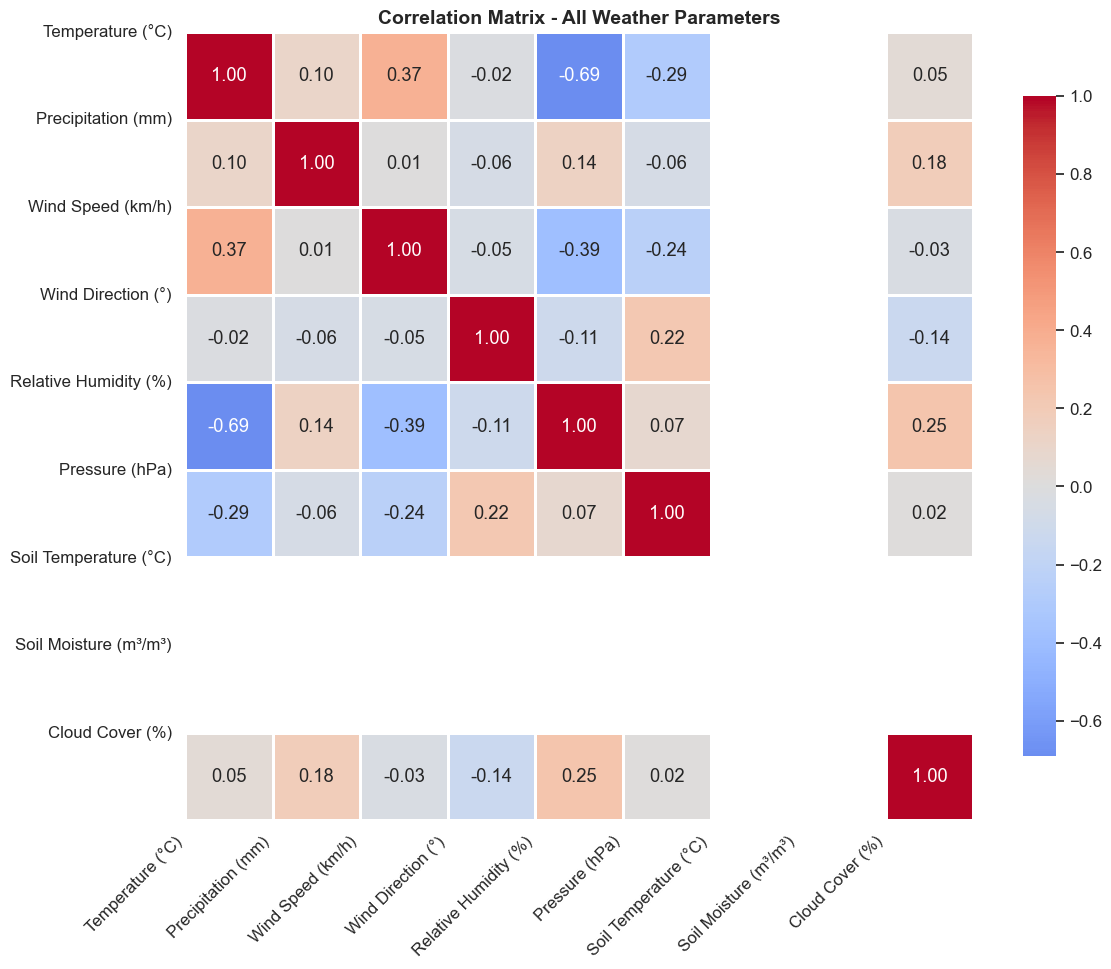

In [35]:
# Cell 31: Correlation heatmap - All parameters
if not df_all.empty:
    # Select weather parameters that exist in the dataframe
    available_params = [p for p in WEATHER_PARAMS if p in df_all.columns]
    
    if len(available_params) > 1:
        correlation_matrix = df_all[available_params].corr()
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                   center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        
        # Update labels
        labels = [PARAM_LABELS.get(p, p) for p in available_params]
        plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
        plt.yticks(range(len(labels)), labels, rotation=0)
        
        plt.title('Correlation Matrix - All Weather Parameters', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("⚠ Not enough parameters for correlation analysis")
else:
    print("⚠ Insufficient data for correlation analysis")

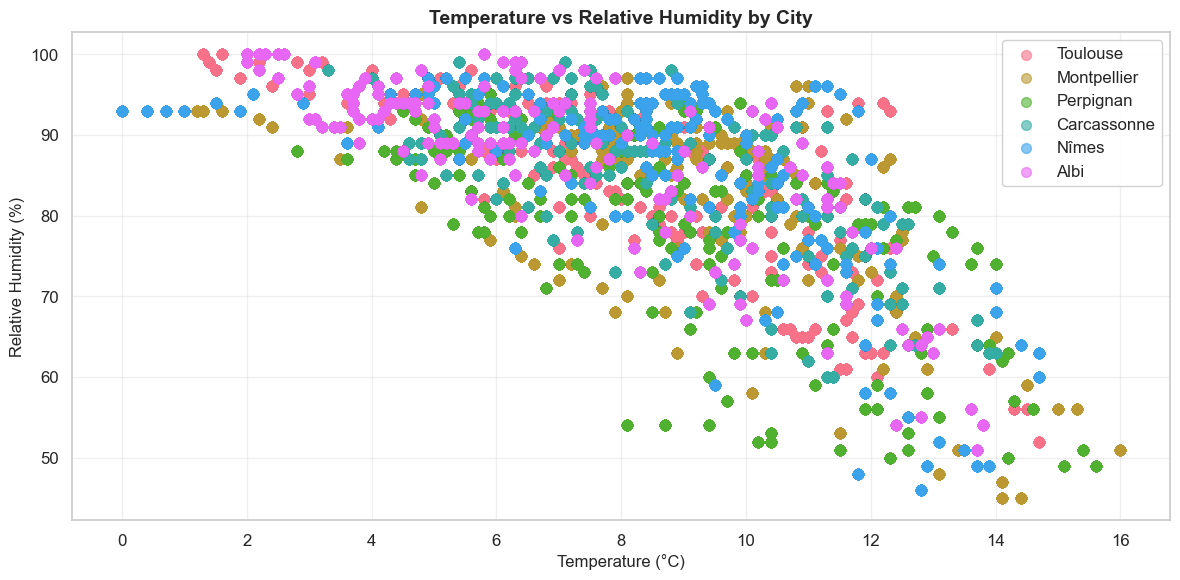

Overall correlation: -0.691


In [36]:
# Cell 32: Scatter plot - Temperature vs Humidity
if not df_all.empty and 'temperature_2m' in df_all.columns and 'relative_humidity_2m' in df_all.columns:
    plt.figure(figsize=(12, 6))
    
    for i, city in enumerate(CITIES):
        city_data = df_all[df_all['city'] == city]
        if not city_data.empty:
            plt.scatter(city_data['temperature_2m'], city_data['relative_humidity_2m'],
                       label=city, color=CITY_COLORS[i], alpha=0.6, s=50)
    
    plt.title('Temperature vs Relative Humidity by City', fontsize=14, fontweight='bold')
    plt.xlabel('Temperature (°C)', fontsize=12)
    plt.ylabel('Relative Humidity (%)', fontsize=12)
    plt.legend(loc='best', framealpha=0.9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate overall correlation
    corr = df_all[['temperature_2m', 'relative_humidity_2m']].corr().iloc[0, 1]
    print(f"Overall correlation: {corr:.3f}")
else:
    print("⚠ Insufficient data for temperature vs humidity scatter plot")

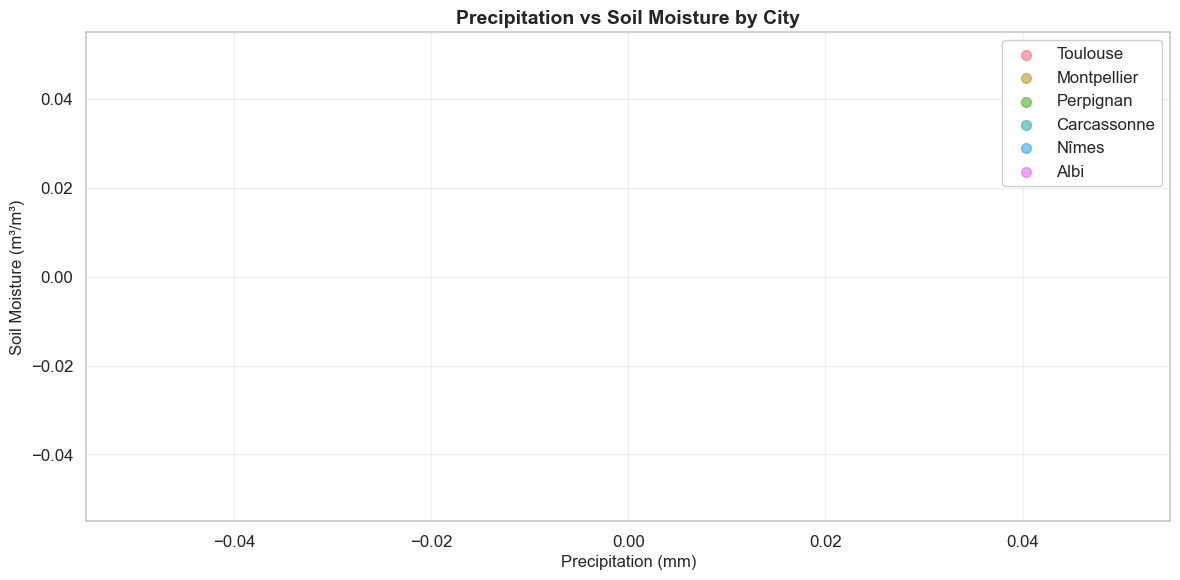

Overall correlation: nan


In [37]:
# Cell 33: Scatter plot - Precipitation vs Soil Moisture
if not df_all.empty and 'precipitation' in df_all.columns and 'soil_moisture_0_to_7cm' in df_all.columns:
    plt.figure(figsize=(12, 6))
    
    for i, city in enumerate(CITIES):
        city_data = df_all[df_all['city'] == city]
        if not city_data.empty:
            plt.scatter(city_data['precipitation'], city_data['soil_moisture_0_to_7cm'],
                       label=city, color=CITY_COLORS[i], alpha=0.6, s=50)
    
    plt.title('Precipitation vs Soil Moisture by City', fontsize=14, fontweight='bold')
    plt.xlabel('Precipitation (mm)', fontsize=12)
    plt.ylabel('Soil Moisture (m³/m³)', fontsize=12)
    plt.legend(loc='best', framealpha=0.9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate overall correlation
    corr = df_all[['precipitation', 'soil_moisture_0_to_7cm']].corr().iloc[0, 1]
    print(f"Overall correlation: {corr:.3f}")
else:
    print("⚠ Insufficient data for precipitation vs soil moisture scatter plot")

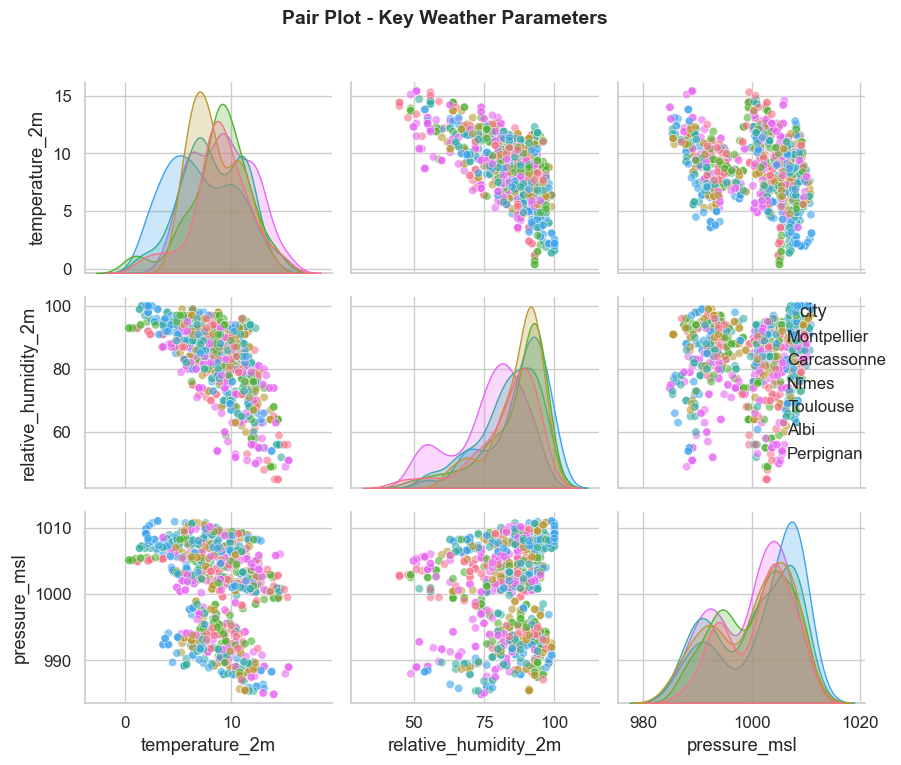

In [38]:
# Cell 34: Pair plot subset - Key parameters
if not df_all.empty:
    # Select key parameters for pair plot
    key_params = ['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'city']
    available_key_params = [p for p in key_params if p in df_all.columns or p == 'city']
    
    if len(available_key_params) >= 3:
        plot_df = df_all[available_key_params].dropna()
        
        if not plot_df.empty and len(plot_df) > 10:
            # Sample data if too large (for performance)
            if len(plot_df) > 1000:
                plot_df = plot_df.sample(n=1000, random_state=42)
            
            g = sns.pairplot(plot_df, hue='city', palette=CITY_COLORS, 
                           diag_kind='kde', plot_kws={'alpha': 0.6})
            g.fig.suptitle('Pair Plot - Key Weather Parameters', fontsize=14, fontweight='bold', y=1.02)
            plt.tight_layout()
            plt.show()
        else:
            print("⚠ Not enough data points for pair plot")
    else:
        print("⚠ Not enough parameters available for pair plot")
else:
    print("⚠ Insufficient data for pair plot")

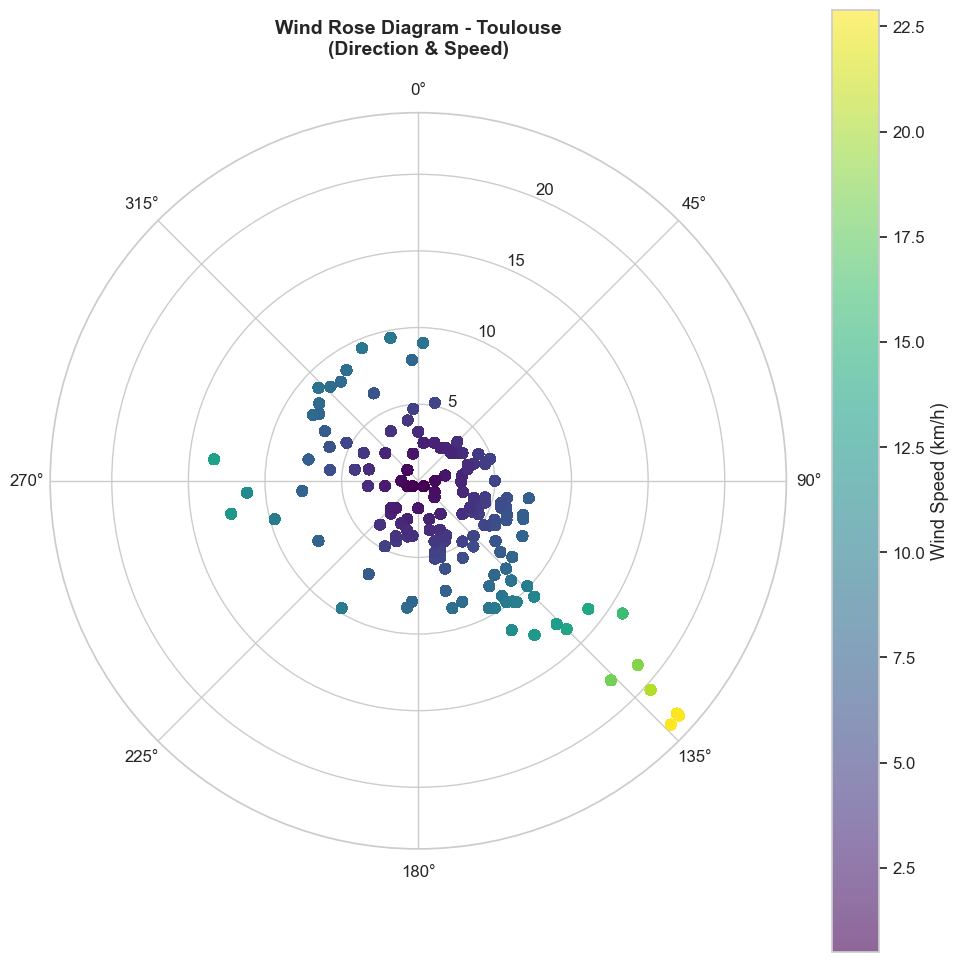

In [39]:
# Cell 35: Wind rose diagram
if not df_all.empty and 'wind_speed_10m' in df_all.columns and 'wind_direction_10m' in df_all.columns:
    # Select data for Toulouse as example
    city_name = 'Toulouse'
    city_data = df_all[df_all['city'] == city_name][['wind_speed_10m', 'wind_direction_10m']].dropna()
    
    if not city_data.empty and len(city_data) > 5:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='polar')
        
        # Convert wind direction to radians
        theta = np.deg2rad(city_data['wind_direction_10m'].values)
        r = city_data['wind_speed_10m'].values
        
        # Create wind rose
        scatter = ax.scatter(theta, r, c=r, cmap='viridis', alpha=0.6, s=50)
        
        # Add colorbar
        plt.colorbar(scatter, ax=ax, label='Wind Speed (km/h)')
        
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_title(f'Wind Rose Diagram - {city_name}\n(Direction & Speed)', 
                    fontsize=14, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠ Insufficient wind data for {city_name}")
else:
    print("⚠ Insufficient data for wind rose diagram")

## Section 7: Statistical Summaries

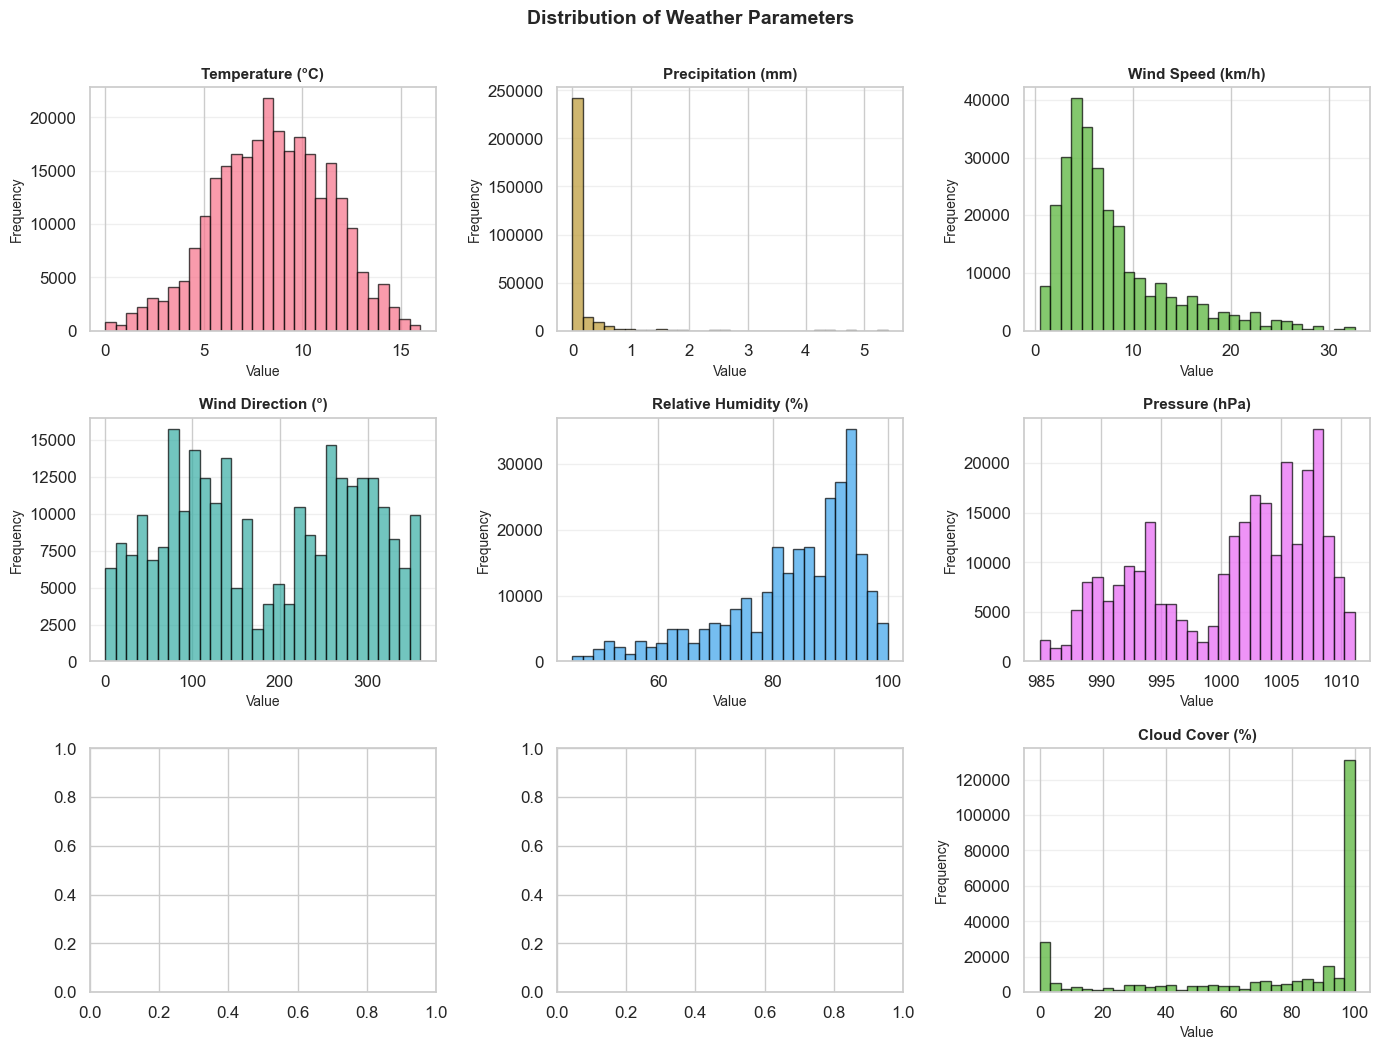

In [40]:
# Cell 36: Distribution histograms for each weather parameter
if not df_all.empty:
    available_params = [p for p in WEATHER_PARAMS if p in df_all.columns]
    
    if available_params:
        # Create grid layout
        n_params = len(available_params)
        n_cols = 3
        n_rows = (n_params + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 3.5))
        axes = axes.flatten() if n_params > 1 else [axes]
        
        for idx, param in enumerate(available_params):
            data = df_all[param].dropna()
            if not data.empty:
                axes[idx].hist(data, bins=30, color=CITY_COLORS[idx % len(CITY_COLORS)], 
                             alpha=0.7, edgecolor='black')
                axes[idx].set_title(PARAM_LABELS.get(param, param), fontsize=11, fontweight='bold')
                axes[idx].set_xlabel('Value', fontsize=10)
                axes[idx].set_ylabel('Frequency', fontsize=10)
                axes[idx].grid(True, alpha=0.3, axis='y')
        
        # Hide unused subplots
        for idx in range(n_params, len(axes)):
            axes[idx].set_visible(False)
        
        plt.suptitle('Distribution of Weather Parameters', fontsize=14, fontweight='bold', y=1.00)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠ No parameters available for distribution plots")
else:
    print("⚠ Insufficient data for distribution histograms")

In [41]:
# Cell 37: Comprehensive summary statistics table
if not df_all.empty:
    available_params = [p for p in WEATHER_PARAMS if p in df_all.columns]
    
    if available_params:
        summary_stats = df_all[available_params].describe().T
        summary_stats['median'] = df_all[available_params].median()
        
        # Reorder columns
        summary_stats = summary_stats[['count', 'min', 'max', 'mean', 'median', 'std']]
        
        # Add parameter labels
        summary_stats.index = [PARAM_LABELS.get(idx, idx) for idx in summary_stats.index]
        
        print("\nCOMPREHENSIVE SUMMARY STATISTICS")
        print("=" * 100)
        display(summary_stats.round(2))
    else:
        print("⚠ No parameters available for summary statistics")
else:
    print("⚠ Insufficient data for summary statistics")


COMPREHENSIVE SUMMARY STATISTICS


,count,min,max,mean,median,std
Temperature (°C),278040.0,-0.0,16.0,8.47,8.5,2.90
Precipitation (mm),278040.0,0.0,5.4,0.10,0.0,0.39
Wind Speed (km/h),278040.0,0.5,32.6,7.80,6.0,5.66
Wind Direction (°),278040.0,1.0,360.0,184.22,177.0,104.23
Relative Humidity (%),278040.0,45.0,100.0,83.44,87.0,11.70
Pressure (hPa),278040.0,984.9,1011.1,1000.80,1002.5,6.85
Cloud Cover (%),278040.0,0.0,100.0,73.22,94.0,35.58


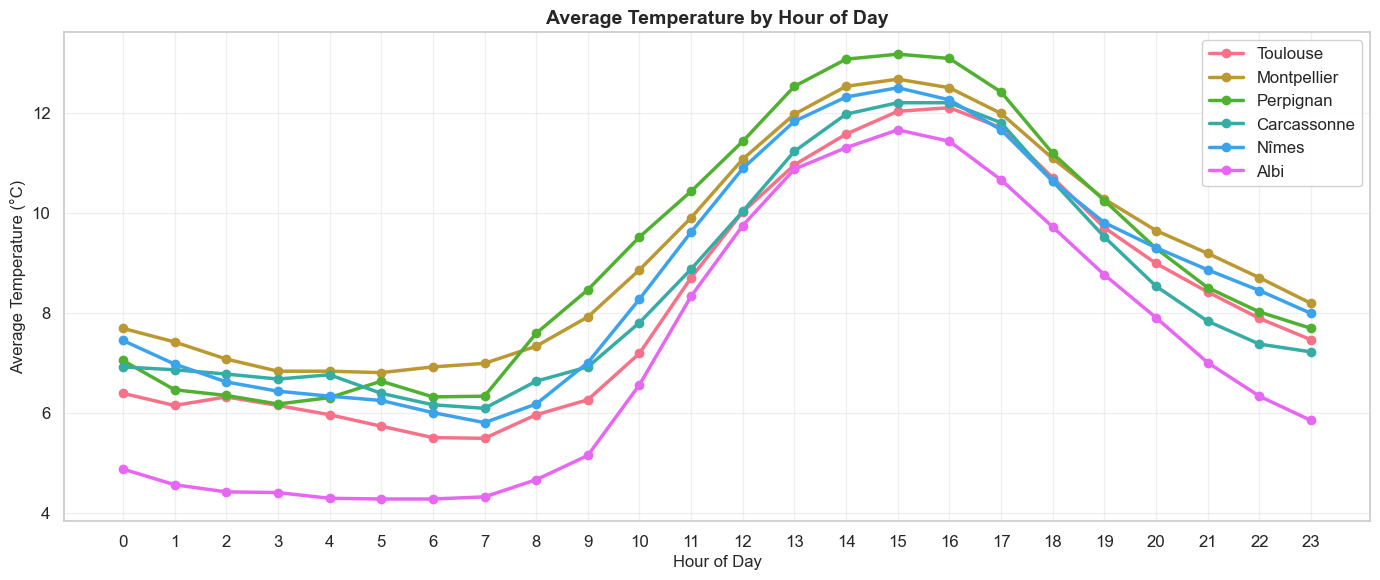

In [42]:
# Cell 38: Hourly aggregations - Average temperature by hour of day
if not df_all.empty and 'temperature_2m' in df_all.columns:
    # Extract hour from index
    df_all_copy = df_all.copy()
    df_all_copy['hour'] = df_all_copy.index.hour
    
    # Calculate average by hour and city
    hourly_temp = df_all_copy.groupby(['hour', 'city'])['temperature_2m'].mean().unstack()
    
    plt.figure(figsize=(14, 6))
    
    for i, city in enumerate(CITIES):
        if city in hourly_temp.columns:
            plt.plot(hourly_temp.index, hourly_temp[city], 
                    label=city, color=CITY_COLORS[i], linewidth=2.5, marker='o', markersize=6)
    
    plt.title('Average Temperature by Hour of Day', fontsize=14, fontweight='bold')
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Average Temperature (°C)', fontsize=12)
    plt.xticks(range(0, 24))
    plt.legend(loc='best', framealpha=0.9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Insufficient data for hourly aggregation")

In [43]:
# Cell 39: Data quality summary
if not df_all.empty:
    print("\nDATA QUALITY SUMMARY")
    print("=" * 80)
    print(f"Total records: {len(df_all):,}")
    print(f"Date range: {df_all.index.min()} to {df_all.index.max()}")
    print(f"Time span: {df_all.index.max() - df_all.index.min()}")
    print(f"\nCities covered: {df_all['city'].nunique()}")
    print(f"Cities: {', '.join(sorted(df_all['city'].unique()))}")
    
    print("\nData completeness by parameter:")
    for param in WEATHER_PARAMS:
        if param in df_all.columns:
            completeness = (1 - df_all[param].isna().sum() / len(df_all)) * 100
            print(f"  {PARAM_LABELS.get(param, param)}: {completeness:.1f}%")
    
    print("=" * 80)
else:
    print("⚠ No data available for quality summary")


DATA QUALITY SUMMARY
Total records: 278,040
Date range: 2026-02-04 00:00:00 to 2026-02-10 23:00:00
Time span: 6 days 23:00:00

Cities covered: 6
Cities: Albi, Carcassonne, Montpellier, Nîmes, Perpignan, Toulouse

Data completeness by parameter:
  Temperature (°C): 100.0%
  Precipitation (mm): 100.0%
  Wind Speed (km/h): 100.0%
  Wind Direction (°): 100.0%
  Relative Humidity (%): 100.0%
  Pressure (hPa): 100.0%
  Soil Temperature (°C): 0.0%
  Soil Moisture (m³/m³): 0.0%
  Cloud Cover (%): 100.0%


In [44]:
# Cell 40: Export processed data to CSV
if not df_all.empty:
    # Create export directory if it doesn't exist
    export_dir = os.path.join(os.path.dirname(os.getcwd()), 'exports')
    os.makedirs(export_dir, exist_ok=True)
    
    # Generate filename with timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'weather_data_{timestamp}.csv'
    filepath = os.path.join(export_dir, filename)
    
    # Export to CSV
    df_all.to_csv(filepath)
    
    print("✓ Data exported successfully")
    print(f"✓ File location: {filepath}")
    print(f"✓ Records exported: {len(df_all):,}")
    print(f"✓ File size: {os.path.getsize(filepath) / 1024:.2f} KB")
    
    # Also create a summary export
    summary_filename = f'weather_summary_{timestamp}.csv'
    summary_filepath = os.path.join(export_dir, summary_filename)
    
    available_params = [p for p in WEATHER_PARAMS if p in df_all.columns]
    if available_params:
        summary_df = df_all.groupby('city')[available_params].agg(['mean', 'min', 'max', 'std'])
        summary_df.to_csv(summary_filepath)
        print(f"✓ Summary exported: {summary_filepath}")
else:
    print("⚠ No data available for export")

✓ Data exported successfully
✓ File location: c:\Users\terra\Desktop\Big-data\exports\weather_data_20260204_160638.csv
✓ Records exported: 278,040
✓ File size: 27208.58 KB
✓ Summary exported: c:\Users\terra\Desktop\Big-data\exports\weather_summary_20260204_160638.csv


## Conclusion

This notebook provides comprehensive visualization and analysis of weather data from the Occitanie region, including:

1. **Time Series Analysis**: Trends over time for all weather parameters
2. **City Comparisons**: Side-by-side comparisons of conditions across all 6 cities
3. **Correlation Analysis**: Relationships between different weather parameters
4. **Statistical Summaries**: Distribution analysis and descriptive statistics
5. **Data Export**: Processed data saved for further analysis

### Next Steps

- Increase the time window (e.g., `hours=48` or `hours=168` for a week)
- Create custom visualizations for specific analysis needs
- Integrate with additional data sources
- Set up automated reporting

### Tips

- Run cells sequentially from top to bottom
- Adjust the `hours` parameter in data fetching functions to change the time window
- Ensure MongoDB is running: `docker-compose up -d mongodb`
- If visualizations are empty, wait for more data to be collected by the DAG